try to find a set of '3D sensative' molecules, for example, based on how many conformers are generated when doing conformer generation with pruning

In [1]:
from rdkit import Chem
import gzip
from rdkit.Chem import rdDistGeom
import pickle
import rdkit
import os
print(f'RDKit version: {rdkit.__version__}')


import time
numConfs=100
def generate_confs(smiles):
    etkdg = rdDistGeom.ETKDGv3()
    etkdg.randomSeed = 0xa700f
    etkdg.verbose = False
    etkdg.numThreads = 4
    etkdg.trackFailures = True
    etkdg.useRandomCoords = True
    etkdg.pruneRmsThresh = 0.1
    confs_generated = []

    for smi in smiles:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            print(f'Failed to create mol from SMILES: {smi}')
            continue
        m = Chem.AddHs(m)
        try:
            rdDistGeom.EmbedMultipleConfs(m,numConfs = numConfs, params = etkdg)
        except:
            print(f'Failed to generate conformers for SMILES: {smi}')
            continue
        confs_generated.append(m.GetNumConformers())
    return confs_generated

RDKit version: 2023.03.3


In [2]:
import pandas as pd
df = pd.read_csv('OPERA_Naef_Training.csv')
molblocks = df['molblock'].tolist()
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
smiles = [Chem.MolToSmiles(m) for m in mols]

start = time.time()
confs_generated = generate_confs(smiles)
end = time.time()
print(confs_generated)


[10:52:28] Warning: molecule is tagged as 3D, but all Z coords are zero
[10:52:28] Warning: molecule is tagged as 3D, but all Z coords are zero
[10:52:28] Warning: molecule is tagged as 3D, but all Z coords are zero


Failed to generate conformers for SMILES: C=CCCCCCCCCCCCCCC


In [ ]:
#add the number of conformers to the dataframe
df['confs'] = confs_generated
df.to_csv('OPERA_Naef_Training_incl_num_confs.csv', index=False)

In [ ]:
#save the results
data = {'smiles':smiles, 'confs_generated':confs_generated,'molblocks':molblocks}
with open('confs_generated.pkl', 'wb') as f:
    pickle.dump(data, f)
    


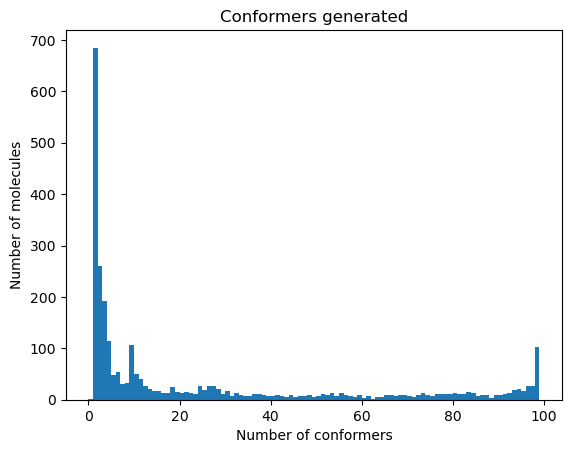

In [2]:
#histogram
#load data
import pickle
with open('confs_generated.pkl', 'rb') as f:
    data = pickle.load(f)
smiles = data['smiles']
confs_generated = data['confs_generated']
import matplotlib.pyplot as plt
plt.hist(confs_generated, bins=range(0, 100, 1))
plt.title('Conformers generated')
plt.xlabel('Number of conformers')
plt.ylabel('Number of molecules')
plt.show()

In [ ]:
molregnos = df['molregno'].tolist()
print(len(molregnos),len(confs_generated))
#make dict molregno:confs
molregno_confs = dict(zip(molregnos, confs_generated))
with open('molregno_confs.pkl', 'wb') as f:
    pickle.dump(molregno_confs, f)

3018 3018


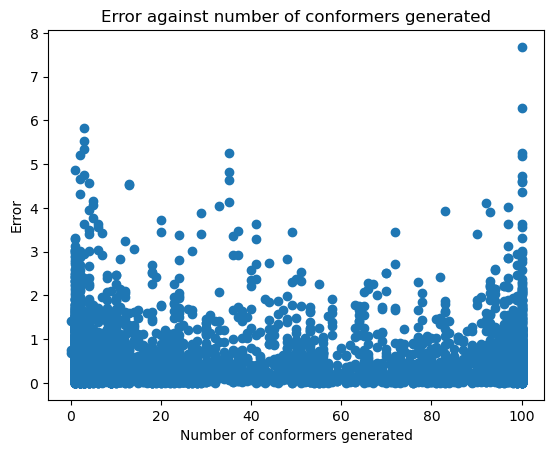

In [5]:
#load data_xgboost_physchem
import pandas as pd
molregno_confs = pickle.load(open('molregno_confs.pkl', 'rb'))
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_PhysChem.pkl', 'rb') as f:
    data_xgboost_physchem = pickle.load(f)
pred_list_xgboost_physchem = data_xgboost_physchem['pred_list']
ys_list_xgboost_physchem = data_xgboost_physchem['ys_list']
molregnos_xgboost_physchem = data_xgboost_physchem['molregnos']
#make flat
pred_list_xgboost_physchem = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem = [item for sublist in molregnos_xgboost_physchem for item in sublist]
#make df
df_xgboost_physchem = pd.DataFrame({'molregno':molregnos_xgboost_physchem, 'pred':pred_list_xgboost_physchem, 'ys':ys_list_xgboost_physchem})
df_xgboost_physchem
confs_xgboost_physchem = [molregno_confs[molregno] for molregno in molregnos_xgboost_physchem]
df_xgboost_physchem['confs_generated'] = confs_xgboost_physchem
df_xgboost_physchem
#add error
df_xgboost_physchem['Absolute error'] = abs(df_xgboost_physchem['ys'] - df_xgboost_physchem['pred'])
#plot error against number of conformers generated
plt.scatter(df_xgboost_physchem['confs_generated'], df_xgboost_physchem['Absolute error'])
plt.xlabel('Number of conformers generated')
plt.ylabel('Error')
plt.title('Error against number of conformers generated')
plt.show()

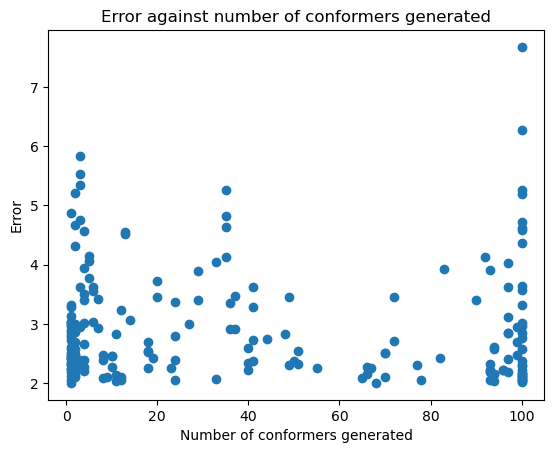

In [6]:
#zoom on error > 2
df_xgboost_physchem_zoom = df_xgboost_physchem[df_xgboost_physchem['Absolute error'] > 2]
plt.scatter(df_xgboost_physchem_zoom['confs_generated'], df_xgboost_physchem_zoom['Absolute error'])
plt.xlabel('Number of conformers generated')
plt.ylabel('Error')
plt.title('Error against number of conformers generated')
plt.show()

In [7]:
#add confs to df
confs_xgboost_physchem = [molregno_confs[molregno] for molregno in molregnos_xgboost_physchem]
df_xgboost_physchem['confs_generated'] = confs_xgboost_physchem
df_xgboost_physchem

,molregno,pred,ys,confs_generated,Absolute error
0,3265,3.899125,3.857102,9,0.042024
1,2404,-3.187017,-0.962598,96,2.224419
2,766,0.105732,0.271002,1,0.165270
3,75,3.637582,3.931102,11,0.293521
4,656,-2.213919,-2.212298,100,0.001621
...,...,...,...,...,...
6035,3406,3.560667,3.500801,1,0.059866
6036,607,3.460873,3.487001,3,0.026128
6037,2811,3.809885,3.454202,9,0.355683
6038,765,-5.615860,-5.600899,92,0.014961


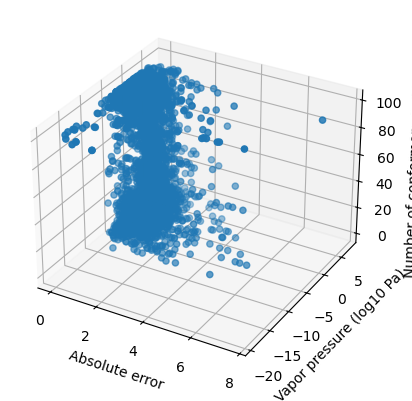

In [10]:
#can we do a 3D plot? ys, confs_generated, abs error
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_xgboost_physchem['Absolute error'], df_xgboost_physchem['ys'], df_xgboost_physchem['confs_generated'])
ax.set_xlabel('Absolute error')
ax.set_ylabel('Vapor pressure (log10 Pa)')
ax.set_zlabel('Number of conformers generated')
plt.show()

In [15]:
#normality test for all three
from scipy.stats import shapiro
print(shapiro(df_xgboost_physchem['Absolute error']))
print(shapiro(df_xgboost_physchem['ys']))
print(shapiro(df_xgboost_physchem['confs_generated']))
#print the kendall tau between ys and absoulte error, and confs and absolute error, and confs and ys
from scipy.stats import kendalltau
print(kendalltau(df_xgboost_physchem['ys'], df_xgboost_physchem['Absolute error']))
print(kendalltau(df_xgboost_physchem['confs_generated'], df_xgboost_physchem['Absolute error']))
print(kendalltau(df_xgboost_physchem['ys'], df_xgboost_physchem['confs_generated']))

ShapiroResult(statistic=0.6743950843811035, pvalue=0.0)
ShapiroResult(statistic=0.9472267031669617, pvalue=4.572436889091878e-42)
ShapiroResult(statistic=0.7453516721725464, pvalue=0.0)
SignificanceResult(statistic=-0.23730051689106366, pvalue=2.7829368452813836e-168)
SignificanceResult(statistic=0.04764771640651515, pvalue=8.150721683454962e-08)
SignificanceResult(statistic=-0.10948319854325858, pvalue=6.877662496857381e-35)


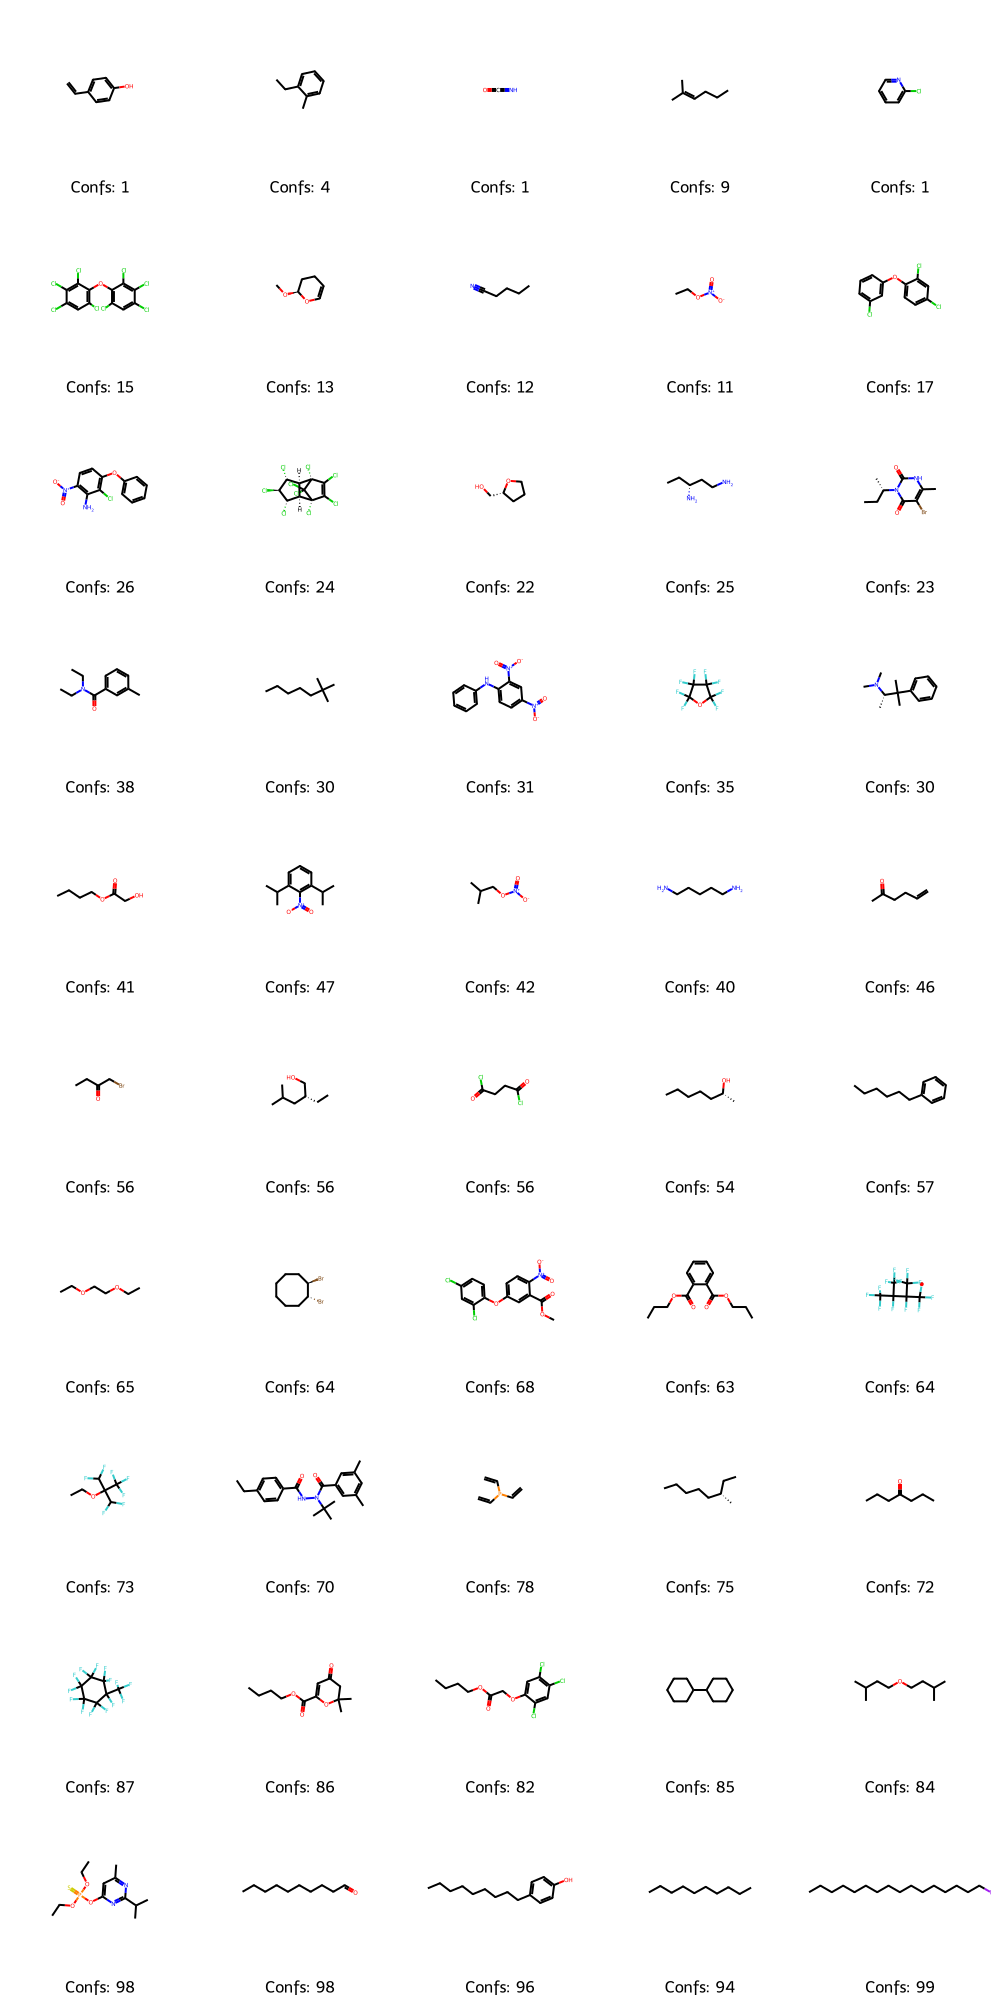

In [21]:
#lets also get a bit of an idea about what these molecules look like. From each bin (0-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-100) we will take 5 molecules and visualize them
import numpy as np
df = pd.read_csv('OPERA_Naef_Training_incl_num_confs.csv')
bins = np.linspace(0, 100, 11)
df['bin'] = np.digitize(df['confs'], bins)
mols = []
for i in range(1,11):
    df_bin = df_xgboost_physchem[df_xgboost_physchem['bin'] == i]
    mols_bin = df_bin['molregno'].tolist()
    mols_bin = mols_bin[:5]
    mols.extend(mols_bin)
df_sampled = df[df['molregno'].isin(mols)]
#sort by bin
df_sampled = df_sampled.sort_values(by='bin')
molblocks = df_sampled['molblock'].tolist()
num_confs_list = df_sampled['confs'].tolist()
from rdkit.Chem import Draw
from rdkit import Chem
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
mols_2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]  
img = Draw.MolsToGridImage(mols_2d, molsPerRow=5, subImgSize=(200,200), legends=[f'Confs: {num_confs_list[i]}' for i in range(len(mols))])
img

confs
1      685
100    278
2      260
3      192
4      115
      ... 
49       5
88       4
60       3
62       2
0        2
Name: count, Length: 101, dtype: int64


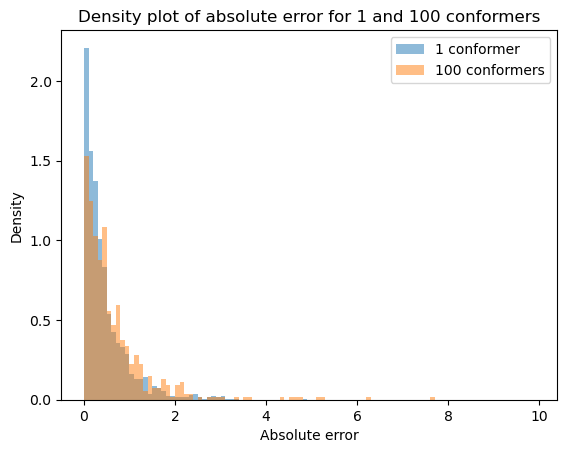

KstestResult(statistic=0.15879409769335143, pvalue=5.118005358579461e-09, statistic_location=0.3491660944314696, statistic_sign=1)


In [37]:
#count: how many with 100, how many with 1
print(df['confs'].value_counts())
#get distribution of of errors for confs = 1 and confs = 100
df_1 = df[df['confs'] == 1]
df_100 = df[df['confs'] == 100]
molregnos_1 = df_1['molregno'].tolist()
molregnos_100 = df_100['molregno'].tolist()
df_xgboost_physchem_1 = df_xgboost_physchem[df_xgboost_physchem['molregno'].isin(molregnos_1)]
df_xgboost_physchem_100 = df_xgboost_physchem[df_xgboost_physchem['molregno'].isin(molregnos_100)]
#plot histogram density plot of Absolute error of thes two
import seaborn as sns
plt.hist(df_xgboost_physchem_1['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='1 conformer')
plt.hist(df_xgboost_physchem_100['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='100 conformers')
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.title('Density plot of absolute error for 1 and 100 conformers')
plt.show()

#are these two statistically different? use ks test
from scipy.stats import ks_2samp
print(ks_2samp(df_xgboost_physchem_1['Absolute error'], df_xgboost_physchem_100['Absolute error']))


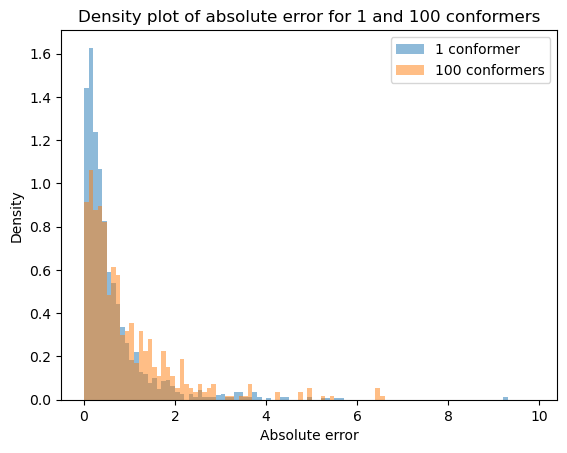

KstestResult(statistic=0.17932708616010856, pvalue=2.1770065625340738e-11, statistic_location=0.6147428768069538, statistic_sign=1)


In [39]:
#repeath for mdfp
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_MDFP.pkl', 'rb') as f:
    data_mdfp = pickle.load(f)
pred_list_mdfp = data_mdfp['pred_list']
ys_list_mdfp = data_mdfp['ys_list']
molregnos_mdfp = data_mdfp['molregnos']
#make flat
pred_list_mdfp = [item for sublist in pred_list_mdfp for item in sublist]
ys_list_mdfp = [item for sublist in ys_list_mdfp for item in sublist]
molregnos_mdfp = [item for sublist in molregnos_mdfp for item in sublist]
#make df
df_mdfp = pd.DataFrame({'molregno':molregnos_mdfp, 'pred':pred_list_mdfp, 'ys':ys_list_mdfp})
df_mdfp
confs_mdfp = [molregno_confs[molregno] for molregno in molregnos_mdfp]
df_mdfp['confs_generated'] = confs_mdfp
df_mdfp
#add error
df_mdfp['Absolute error'] = abs(df_mdfp['ys'] - df_mdfp['pred'])
df_mdfp_1 = df_mdfp[df_mdfp['molregno'].isin(molregnos_1)]
df_mdfp_100 = df_mdfp[df_mdfp['molregno'].isin(molregnos_100)]
#plot histogram density plot of Absolute error of thes two
import seaborn as sns
plt.hist(df_mdfp_1['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='1 conformer')
plt.hist(df_mdfp_100['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='100 conformers')
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.title('Density plot of absolute error for 1 and 100 conformers')
plt.show()

#are these two statistically different? use ks test
from scipy.stats import ks_2samp
print(ks_2samp(df_mdfp_1['Absolute error'], df_mdfp_100['Absolute error']))

In [ ]:
from scipy.stats import kruskal

# Assuming 'prediction_error' and 'conformers' are your variable arrays
h_statistic, p_value = kruskal(*[prediction_error[conformers == level] for level in np.unique(conformers)])

print(f"Kruskal-Wallis H-statistic: {h_statistic}")
print(f"P-value: {p_value}")


In [ ]:
molregnos_xgboost_physchem[0]

0       3265
1       2404
2        766
3         75
4        656
       ...  
599    16709
600      316
601      450
602      362
603    16800
Name: molregno, Length: 604, dtype: int64